In [4]:
# !unzip bert-base-uncased.zip

In [2]:
# %pip install seaborn --quiet

In [4]:
import os
from tqdm import tqdm
from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

import torch
# import torch_npu
from transformers import BertTokenizer, BertModel

import matplotlib.pyplot as plt
import seaborn as sns

/home/d.kornilov/study/SMILES 2025 Harbin/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv("icd10_categories_descriptions.csv").drop("Unnamed: 0", axis=1)

In [7]:
df.head()

icd10_category                                  description
0            K76                      Other diseases of liver
1            R18                                      Ascites
2            K74              Fibrosis and cirrhosis of liver
3            B19                  Unspecified viral hepatitis
4            J44  Other chronic obstructive pulmonary disease

# BERT sentence embeddings

In [8]:
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu" #"npu"
DEVICE

'cuda:2'

In [10]:
# tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased', cache_dir='./bert-base-uncased/', local_files_only=True)
# model = BertModel.from_pretrained('google-bert/bert-base-uncased', cache_dir='./bert-base-uncased/', local_files_only=True, device_map="npu")

tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = BertModel.from_pretrained('google-bert/bert-base-uncased', device_map=DEVICE)

In [11]:
def get_cls(sentence):
    input_ids = tokenizer(sentence)["input_ids"]
    
    with torch.no_grad():
        outputs = model(torch.tensor(input_ids).unsqueeze(0).to(DEVICE))
        cls = outputs.last_hidden_state[:, 0, :].cpu()[0]  # [CLS] token

    return np.array(cls)

def get_cls_batch(sentences):
    input_ids = tokenizer(sentences)["input_ids"]
    
    embeddings = []
    # for sentence_ids in tqdm(input_ids):
    for sentence_ids in input_ids:
        with torch.no_grad():
            outputs = model(torch.tensor(sentence_ids).unsqueeze(0).to(DEVICE))
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu())  # [CLS] token

    return np.array(torch.cat(embeddings))

In [12]:
df["cls"] = df["description"].apply(lambda x: get_cls(x))

/tmp/ipykernel_232274/544400558.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(cls)


In [14]:
df.head()

icd10_category                                  description  \
0            K76                      Other diseases of liver   
1            R18                                      Ascites   
2            K74              Fibrosis and cirrhosis of liver   
3            B19                  Unspecified viral hepatitis   
4            J44  Other chronic obstructive pulmonary disease   

                                                 cls  
0  [-0.29168436, 0.5248304, -0.6188823, -0.408091...  
1  [-0.4255143, 0.04044315, -0.4146737, -0.147538...  
2  [-0.7025464, 0.16387954, -0.60320395, -0.52702...  
3  [-0.42507905, 0.0839555, -0.70060223, -0.34379...  
4  [-0.45927984, 0.1861519, -0.65849656, -0.76039...

In [15]:
df.to_csv("bert_embeddings.tsv", sep="\t")

In [16]:
similarity_scores = cosine_similarity(list(df["cls"].values), list(df["cls"].values))

In [17]:
similarity_scores = pd.DataFrame(data=similarity_scores, index=df["icd10_category"].values, columns=df["icd10_category"].values)

In [18]:
similarity_scores = similarity_scores.sort_index().sort_index(axis=1)

In [19]:
similarity_scores

A01       A02       A03       A04       A05       A06       A07  \
A01  1.000000  0.859168  0.665948  0.859246  0.823354  0.739037  0.829982   
A02  0.859168  1.000000  0.777414  0.973218  0.887753  0.864736  0.942054   
A03  0.665948  0.777414  1.000000  0.790528  0.789908  0.918583  0.804874   
A04  0.859246  0.973218  0.790528  1.000000  0.897945  0.869180  0.958340   
A05  0.823354  0.887753  0.789908  0.897945  1.000000  0.848437  0.882071   
..        ...       ...       ...       ...       ...       ...       ...   
Z95  0.779557  0.787306  0.655556  0.788990  0.778845  0.706585  0.809560   
Z96  0.764027  0.850066  0.756970  0.860766  0.832941  0.816247  0.868457   
Z97  0.739333  0.855486  0.779775  0.881045  0.858013  0.842539  0.869061   
Z98  0.708704  0.833847  0.834105  0.863149  0.860299  0.872275  0.880360   
Z99  0.748689  0.813223  0.777532  0.832367  0.881154  0.828758  0.831070   

          A08       A09       A15  ...       Z90       Z91       Z92  \
A01  0.882923  0.872734  0.820178  ...  0.805651  0.770802  0.720195   
A02  0.934136  0.913743  0.821827  ...  0.833916  0.822464  0.804428   
A03  0.738340  0.728651  0.668020  ...  0.775290  0.732368  0.759687   
A04  0.949515  0.909704  0.810917  ...  0.843768  0.828203  0.841645   
A05  0.885433  0.877449  0.823570  ...  0.887030  0.865707  0.805665   
..        ...       ...       ...  ...       ...       ...       ...   
Z95  0.841138  0.840403  0.831743  ...  0.831475  0.812174  0.785022   
Z96  0.868951  0.858422  0.789356  ...  0.876665  0.840407  0.855125   
Z97  0.857926  0.833825  0.767759  ...  0.872708  0.860505  0.861417   
Z98  0.802405  0.784777  0.704459  ...  0.825974  0.797924  0.857631   
Z99  0.832219  0.822425  0.777742  ...  0.909643  0.905688  0.840748   

          Z93       Z94       Z95       Z96       Z97       Z98       Z99  
A01  0.700822  0.752230  0.779557  0.764027  0.739333  0.708704  0.748689  
A02  0.820144  0.804293  0.787306  0.850066  0.855486  0.833847  0.813223  
A03  0.808036  0.732707  0.655556  0.756970  0.779775  0.834105  0.777532  
A04  0.840376  0.816950  0.788990  0.860766  0.881045  0.863149  0.832367  
A05  0.820866  0.816880  0.778845  0.832941  0.858013  0.860299  0.881154  
..        ...       ...       ...       ...       ...       ...       ...  
Z95  0.751095  0.863822  1.000000  0.915135  0.825481  0.706655  0.790996  
Z96  0.866428  0.886598  0.915135  1.000000  0.935572  0.837904  0.851128  
Z97  0.897306  0.848770  0.825481  0.935572  1.000000  0.869114  0.886346  
Z98  0.885827  0.794254  0.706655  0.837904  0.869114  1.000000  0.862907  
Z99  0.866906  0.834368  0.790996  0.851128  0.886346  0.862907  1.000000  

[1696 rows x 1696 columns]

In [20]:
similarity_scores.to_csv("similarity_scores.csv")

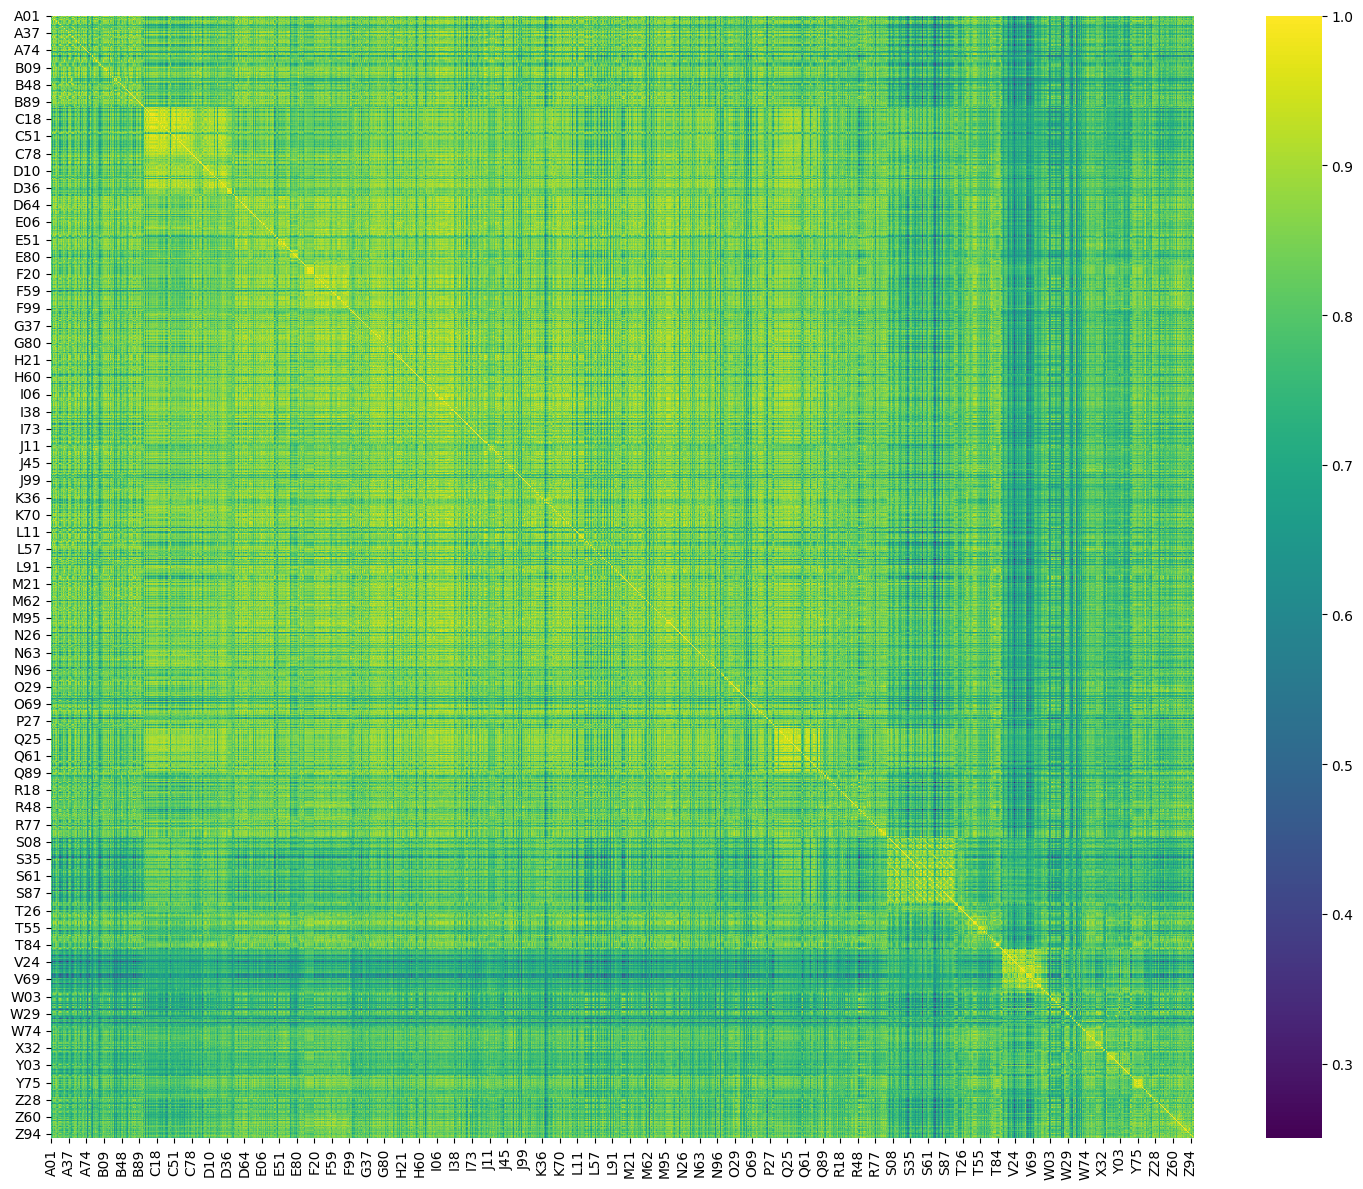

In [22]:
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_scores, cmap ='viridis')
plt.tight_layout()
plt.savefig("pics/cosine_similarity.png", dpi=300, bbox_inches='tight')
plt.show()